In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata14_20.csv')
table.head()

Date  IDStation         NameStation  Ammonia  Arsenic  \
0  2014-01-01T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
1  2014-01-02T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
2  2014-01-03T00:00:00Z        681  Moggio Loc Penscei      0.0      1.1   
3  2014-01-04T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
4  2014-01-05T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   

   Benzo_a_pyrene  Cadmium  Lead  Nikel  NO  ...  IDStation.2  \
0             0.1      NaN   NaN    NaN NaN  ...          111   
1             NaN      NaN   NaN    NaN NaN  ...          111   
2             NaN      0.0   1.1    4.2 NaN  ...          111   
3             0.1      NaN   NaN    NaN NaN  ...          111   
4             NaN      NaN   NaN    NaN NaN  ...          111   

               NameStation.1  Wind_speed  Wind_direction  Temperature  \
0  Cassina Valsassina Moggio    0.443554            99.0    -0.334965   
1  Cassina Valsassina Moggio    0.355915           105.0    -0.486111   
2  Cassina Valsassina Moggio    0.207631           120.0     2.220588   
3  Cassina Valsassina Moggio    1.024926           175.0     2.137063   
4  Cassina Valsassina Moggio    0.666721            94.0     2.416084   

   Relative_humidity  Global_radiation Wind_speed_max  Wind_direction_max  \
0          45.545455         58.097902       1.805594               143.0   
1          83.944444          0.000000       1.767361               153.0   
2          87.042254         30.514085       1.558451               152.0   
3          89.349650          0.202797       3.816783               164.0   
4          86.055944         10.951049       2.797203               136.0   

  Rainfall  
0      0.0  
1      7.8  
2      0.0  
3     35.8  
4     25.0  

[5 rows x 28 columns]

In [ ]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index                  Date  PM10  Ammonia  Wind_speed  Wind_direction  \
0      0  2014-01-01T00:00:00Z   6.0      0.0    0.443554            99.0   
1      1  2014-01-02T00:00:00Z   6.0      0.0    0.355915           105.0   
2      2  2014-01-03T00:00:00Z  11.0      0.0    0.207631           120.0   
3      3  2014-01-04T00:00:00Z   6.0      0.0    1.024926           175.0   
4      4  2014-01-05T00:00:00Z   3.0      0.0    0.666721            94.0   

   Temperature  Rainfall  
0    -0.334965       0.0  
1    -0.486111       7.8  
2     2.220588       0.0  
3     2.137063      35.8  
4     2.416084      25.0

In [ ]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [ ]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [ ]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

In [ ]:
boo = []

for value in reframed.columns:
  boo.append(not(value.startswith("var1(t-"))) # remove the y from all the predictors, as to see how the model performs without the autoregressive component 

reframed = reframed.iloc[:,boo]

reframed.head()


var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  var2(t-4)  \
5        0.0   0.163005   0.275000   0.286365   0.000000        0.0   
6        0.0   0.130139   0.291667   0.282413   0.035199        0.0   
7        0.0   0.074531   0.333333   0.353183   0.000000        0.0   
8        0.0   0.381024   0.486111   0.350999   0.161552        0.0   
9        0.0   0.246694   0.261111   0.358295   0.112816        0.0   

   var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  ...  var3(t+3)  var4(t+3)  \
5   0.130139   0.291667   0.282413   0.035199  ...   0.063516   0.100000   
6   0.074531   0.333333   0.353183   0.000000  ...   0.141334   0.738889   
7   0.381024   0.486111   0.350999   0.161552  ...   0.068566   0.019444   
8   0.246694   0.261111   0.358295   0.112816  ...   0.024003   0.188889   
9   0.075776   0.222222   0.406390   0.000000  ...   0.122816   0.694444   

   var5(t+3)  var6(t+3)  var1(t+4)  var2(t+4)  var3(t+4)  var4(t+4)  \
5   0.392536   0.000000   0.133333        0.0   0.141334   0.738889   
6   0.409331   0.000000   0.122222        0.0   0.068566   0.019444   
7   0.387761   0.000000   0.066667        0.0   0.024003   0.188889   
8   0.425800   0.000000   0.177778        0.0   0.122816   0.694444   
9   0.335977   0.008123   0.066667        0.0   0.043570   0.833333   

   var5(t+4)  var6(t+4)  
5   0.409331   0.000000  
6   0.387761   0.000000  
7   0.425800   0.000000  
8   0.335977   0.008123  
9   0.294106   0.166967  

[5 rows x 55 columns]

In [ ]:
# split into train and test sets
values = reframed.values
n_features = 5 # number of variables, not including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years

boo = []
for value in reframed.columns:
  boo.append('var1(t)' in value or 'var1(t+' in value) # used to single out the future lags of var1 (and not of all others)

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, boo] 
test_X, test_y = test[:, :n_obs], test[:, boo]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 25) 1312 (1312, 5)
(1312, 5, 5) (1312, 5) (780, 5, 5) (780, 5)


# Modeling and training

In [ ]:
%%capture
!pip install keras-tuner
from tensorflow import keras
import keras_tuner as kt

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
        hp_dropout = hp.Choice('dropout', values=[0.0, 0.25, 0.5, 0.75])
        model = Sequential()
        model.add(LSTM(units = hp_units,return_sequences=True, dropout = hp_dropout, input_shape=(train_X.shape[1], train_X.shape[2])))
        for i in range(hp.Int('layers',1,4)):
            model.add(LSTM(units = hp_units, return_sequences=True))
        model.add(LSTM(units = hp_units, return_sequences=False))
        model.add(Dense(5))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )

In [ ]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial =5,
    overwrite=True,
    directory = 'dir',
    project_name = 'tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 10, 'sampling': None}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5, 0.75], 'ordered': True}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=50)
tuner.search(train_X, train_y, epochs=300, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

Trial 1 Complete [00h 01m 31s]
val_loss: 0.08259806036949158

Best val_loss So Far: 0.08259806036949158
Total elapsed time: 00h 01m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in dir/tune_hypermodel
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 30
dropout: 0.0
layers: 2
learning_rate: 0.01
batch_size: 16
Score: 0.08259806036949158


In [ ]:
model = tuner.get_best_models()[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             4320      
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 lstm_2 (LSTM)               (None, 5, 30)             7320      
                                                                 
 lstm_3 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 5)                 155       
                                                                 
Total params: 26,435
Trainable params: 26,435
Non-trainable params: 0
_________________________________________________________________


Epoch 1/160
14/14 - 12s - loss: 0.1470 - val_loss: 0.1006 - 12s/epoch - 826ms/step
Epoch 2/160
14/14 - 0s - loss: 0.0973 - val_loss: 0.0942 - 273ms/epoch - 20ms/step
Epoch 3/160
14/14 - 0s - loss: 0.0974 - val_loss: 0.0908 - 271ms/epoch - 19ms/step
Epoch 4/160
14/14 - 0s - loss: 0.0954 - val_loss: 0.0904 - 282ms/epoch - 20ms/step
Epoch 5/160
14/14 - 0s - loss: 0.0954 - val_loss: 0.0899 - 270ms/epoch - 19ms/step
Epoch 6/160
14/14 - 0s - loss: 0.0949 - val_loss: 0.0894 - 273ms/epoch - 20ms/step
Epoch 7/160
14/14 - 0s - loss: 0.0943 - val_loss: 0.0889 - 266ms/epoch - 19ms/step
Epoch 8/160
14/14 - 0s - loss: 0.0937 - val_loss: 0.0885 - 266ms/epoch - 19ms/step
Epoch 9/160
14/14 - 0s - loss: 0.0931 - val_loss: 0.0881 - 289ms/epoch - 21ms/step
Epoch 10/160
14/14 - 0s - loss: 0.0928 - val_loss: 0.0881 - 262ms/epoch - 19ms/step
Epoch 11/160
14/14 - 0s - loss: 0.0930 - val_loss: 0.0886 - 264ms/epoch - 19ms/step
Epoch 12/160
14/14 - 0s - loss: 0.0928 - val_loss: 0.0886 - 293ms/epoch - 21ms/step
E

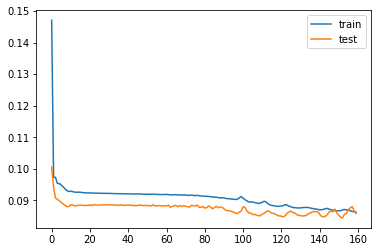

In [ ]:
# design the neural network
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(5)) # prediction for the following 6 days
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=80, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=160, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

#### Prediciton plots

prediction with 2020

In [ ]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!! we keep the 2020 data 
Moggio.head()
values = Moggio.iloc[:,2:].values

# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

boo = []

for value in reframed.columns:
  boo.append(not(value.startswith("var1(t-"))) # remove the y from all the predictors, as to see how the model performs without the autoregressive component 

reframed = reframed.iloc[:,boo]


# split into train and test sets
values = reframed.values
n_features = 5 # number of variables, not including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years

boo = []
for value in reframed.columns:
  boo.append('var1(t)' in value or 'var1(t+' in value) # used to single out the future lags of var1 (and not of all others)

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, boo] 
test_X, test_y = test[:, :n_obs], test[:, boo]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 25) 1312 (1312, 5)
(1312, 5, 5) (1312, 5) (780, 5, 5) (780, 5)


In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
#scale back both the prediction and the test dataset
inv_yhat = []
inv_y = []
a = -5
b = test_X.shape[1]
for i in range(1,yhat.shape[1]+1):

  t = concatenate((yhat[:,(i-1):i], test_X[:, a:b]), axis=1)
  t = scaler.inverse_transform(t)
  inv_yhat.append(t[:,0])

  t = concatenate((test_y[:,(i-1):i], test_X[:, a:b]), axis=1)
  t = scaler.inverse_transform(t)
  inv_y.append(t[:,0])

  a = a - 5
  b = b - 5


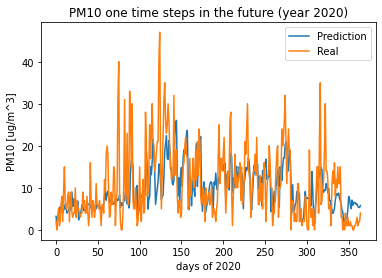

Test RMSE: 8.160


In [ ]:
pyplot.plot(inv_yhat[0][-365:], label = 'Prediction')
pyplot.plot(inv_y[0][-365:][-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 one time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()
rmse = sqrt(mean_squared_error(inv_y[0], inv_yhat[0]))
print('Test RMSE: %.3f' % rmse)

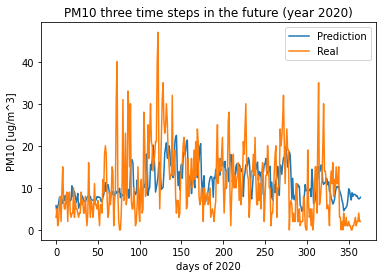

Test RMSE: 9.065


In [ ]:
pyplot.plot(inv_yhat[2][-365:], label = 'Prediction')
pyplot.plot(inv_y[2][-365:][-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 three time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()
rmse = sqrt(mean_squared_error(inv_y[2], inv_yhat[2]))
print('Test RMSE: %.3f' % rmse)

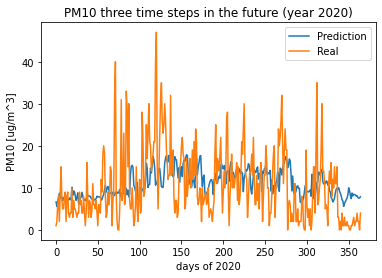

Test RMSE: 9.272


In [ ]:
pyplot.plot(inv_yhat[4][-365:], label = 'Prediction')
pyplot.plot(inv_y[4][-365:][-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 three time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()
rmse = sqrt(mean_squared_error(inv_y[4], inv_yhat[4]))
print('Test RMSE: %.3f' % rmse)

# Lime


In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 2.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9bb0d1f6e1926cc80487fbedf5fa292671096f103c6c8d0f49ad45f080f2fbd7
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_tabular

In [ ]:
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
test_X.shape

(780, 5, 5)

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"], mode='regression')

In [ ]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
test_X[1]

array([[0.22772275, 0.34040976, 0.49166667, 0.8049929 , 0.01353791],
       [0.2722772 , 0.3440421 , 0.35277778, 0.8189919 , 0.03158845],
       [0.2821782 , 0.42023662, 0.49166667, 0.8296864 , 0.00270758],
       [0.2772277 , 0.18730268, 0.5138889 , 0.7904489 , 0.02888086],
       [0.25247523, 0.25320575, 0.5138889 , 0.8327731 , 0.        ]],
      dtype=float32)

In [ ]:
exp.as_list()

[('Ammonia_t-0 > 0.28', 0.08833615903344853),
 ('Rainfall_t-0 <= 0.00', 0.02918737402856392),
 ('0.56 < Temperature_t-0 <= 0.74', 0.009008245159430396),
 ('Wind_direction_t-2 > 0.58', 0.008233111618066419),
 ('Ammonia_t-2 > 0.28', -0.00757376633291459),
 ('Ammonia_t-3 > 0.28', -0.006862669927338302)]